In [1]:
import sys
root = '../../'
sys.path.append(root)   # Done to be able to import the packages and functions

import Utils.hico_evaluation.evaluation as ev
from Utils.custom_sampler import OverSampler
from Utils.custom_loss import MaskedBCELoss
from Utils.annotation_preprocessing import _load_csv_to_tensor
from Utils.train_val_split import train_val_split_hico
from hoi_classifiers import ElementwiseAvgFusionModel

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import random

In [2]:
seed = 42   #note that the model parameters will still be randomly initiated
torch.manual_seed(seed)
random.seed(seed)

### Loading the training set:


In [3]:
# Loading the data:
X_train = torch.load(root + "Embeddings/Combined_Embeddings/train.pt")
y_train = _load_csv_to_tensor(root + "anno/added/anno_augmented_train.csv").T[:,:600] # Transpose to make both first dimensions the #samples.
y_train[y_train.isnan()] = -1

In [4]:
X_test = torch.load(root + "Embeddings/Combined_Embeddings/test.pt")
y_test = _load_csv_to_tensor(root + "anno/added/anno_augmented_test.csv").T[:,:600] # Transpose to make both first dimensions the #samples.
y_test[y_test.isnan()] = -1

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Loading the models:

In [6]:
no_mtl_model = torch.load(root + "Saved Models/best_model_no_multitasklearning.pt").to(device)
mtl_model = torch.load(root + "Saved Models/best_model.pt").to(device)

In [7]:
output_no_mtl = no_mtl_model(X_test.to(device))
output_mtl = mtl_model(X_test.to(device))

#### Calculating the accuraccy of both models: (the number of images where all class annotations match)

In [8]:
(torch.where(((output_mtl[:,:600] >= 0.5).int() == (y_test == 1).to(device)).all(dim=1))[0].shape[0] / y_test.to(device).shape[0]) * 100

30.637813211845106

In [9]:
(torch.where(((output_no_mtl[:,:600] >= 0.5).int() == (y_test == 1).to(device)).all(dim=1))[0].shape[0] / y_test.to(device).shape[0]) * 100

31.693932491199007

#### calculating the APs of both models:

In [12]:
test_map_mtl = ev.eval_vo(output_mtl.T.cpu().detach().numpy(), y_test.T.numpy(),600)[0] * 100

In [13]:
test_map_no_mtl = ev.eval_vo(output_no_mtl.T.cpu().detach().numpy(), y_test.T.numpy(),600)[0] * 100

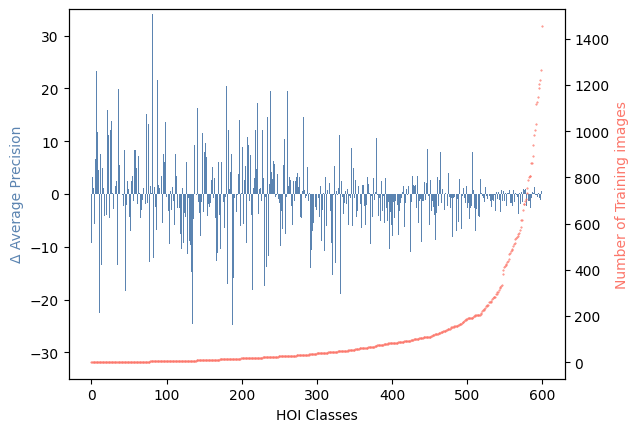

In [19]:
indices = torch.sum((y_train[:,:600] == 1).int(), dim = 0).sort().indices
test_aps = (test_map_mtl - test_map_no_mtl)

fig, ax1 = plt.subplots()

ax1.set_xlabel('HOI Classes')
ax1.set_ylabel('Δ Average Precision', color='#5B84B1FF')
ax1.bar(range(600),test_aps[indices],width=1, color='#5B84B1FF')
ax1.set_ylim(bottom= -35, top= 35)

ax2 = ax1.twinx()
ax2.set_ylabel('Number of Training images', color='#FC766AFF')
ax2.scatter(range(600),torch.sum(y_train == 1, dim = 0)[indices],s = 0.2,color = "#FC766AFF")

plt.savefig('lol.pdf')